In [4]:
#Regression

import pandas as pd
from pycaret.regression import *

# 1) อ่านข้อมูล
df = pd.read_csv(r"C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\unknow-m_1d.csv")

# 2) แปลง timestamp เป็น datetime แล้วเรียงตามเวลา
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', inplace=True)

# 3) สร้างคอลัมน์วันแบบตัวเลข (ordinal) เพื่อให้โมเดลจับลำดับของวันได้ง่ายขึ้น
df['date_ordinal'] = df['date'].map(pd.Timestamp.toordinal)

# 4) ในที่นี้ เราจะทำนาย pm_2_5 โดยใช้ฟีเจอร์ 4 ตัว: [timestamp_ordinal, humidity, pm_10, temperature]
# สร้าง DataFrame ใหม่ที่มีเฉพาะฟีเจอร์ + target
data = df[['date_ordinal', 'humidity', 'temperature', 'pm_2_5']].copy()

# 5) ตั้งค่า PyCaret ในโหมด Regression
#    - target = 'pm_2_5'
#    - fold_strategy = 'timeseries' เพื่อบอกให้ PyCaret split ข้อมูลตามเวลา
#    - fold = 3 (หรือกำหนดเองได้)
#    - session_id = 123 (เพื่อความสามารถในการ reproduce)
reg_setup = setup(
    data=data,
    target='pm_2_5',
    fold_strategy='timeseries',
    fold=3,
    session_id=123,
    numeric_features=['date_ordinal', 'humidity', 'temperature'],
    data_split_shuffle=False,  # ✅ ปิดการสุ่มข้อมูลตอนแบ่ง train/test
    fold_shuffle=False  # ✅ ปิดการ shuffle ข้อมูลใน cross-validation
)


# 6) เปรียบเทียบโมเดลต่าง ๆ เพื่อดูว่าโมเดลไหนแม่นที่สุด (ใช้ค่า default metric เช่น R2, RMSE, MAE)
best_model = compare_models()

# 7) ปรับแต่งโมเดลที่เลือก (tune) หรือสร้างโมเดลเอง
# tuned_model = tune_model(best_model)

# 8) เมื่อได้โมเดลที่พอใจแล้ว ทำการ final เพื่อเตรียมใช้งานจริง
final_model = finalize_model(best_model)

# 9) ประเมินโมเดลบนชุดข้อมูลทดสอบ (PyCaret จะแบ่งให้ตาม time-based folds)
# predict_model() จะให้ผลลัพธ์ (prediction) + คำนวณ error metrics
pred_results = predict_model(final_model)
print(pred_results.head())

# 10) หากต้องการทำนายข้อมูลใหม่ (unseen data) สมมติเราเตรียม data_unseen ไว้
# data_unseen ควรมีคอลัมน์ timestamp_ordinal, humidity, pm_10, temperature
# unseen_preds = predict_model(final_model, data=data_unseen)

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(1452, 4)"
4,Transformed data shape,"(1452, 4)"
5,Transformed train set shape,"(1016, 4)"
6,Transformed test set shape,"(436, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,7.0840,80.4280,8.8697,-0.1931,0.5732,0.6745,0.0133
par,Passive Aggressive Regressor,7.6785,84.3422,9.0632,-0.2281,0.6324,0.9155,0.0167
dummy,Dummy Regressor,7.3812,80.5549,8.9373,-0.2291,0.5964,0.7807,0.0100
ada,AdaBoost Regressor,7.8975,96.3455,9.5682,-0.3520,0.6290,0.8222,0.0500
et,Extra Trees Regressor,7.8961,102.6790,9.9320,-0.4696,0.6432,0.7679,0.0567
knn,K Neighbors Regressor,8.3298,109.9428,10.2121,-0.5382,0.6524,0.8722,0.0300
lightgbm,Light Gradient Boosting Machine,7.9423,107.0583,10.2158,-0.5696,0.6629,0.7486,0.1233
rf,Random Forest Regressor,8.1265,109.9976,10.3387,-0.6131,0.6831,0.7523,0.0733
lr,Linear Regression,8.3216,128.6745,10.8573,-0.8860,0.8444,0.5898,0.0133
lar,Least Angle Regression,8.3216,128.6745,10.8573,-0.8860,0.8444,0.5898,0.0133


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,5.8907,49.3100,7.0221,-0.0011,0.6173,0.8734


      date_ordinal   humidity  temperature     pm_2_5  prediction_label
1016        738849  92.228432    26.323557  11.844190         12.426985
1017        738850  91.814728    26.528961   7.732240         12.427002
1018        738851  96.790894    24.615288   5.285687         12.427019
1019        738852  96.302872    24.793573   4.043248         12.427036
1020        738853  89.681732    27.159864   9.947243         12.427052


In [9]:
# 11) บันทึกโมเดลที่ finalize แล้ว
save_model(final_model, 'pm2.5_regression_model')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['date'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['date_ordinal', 'humidity',
                                              'temperature'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('actual_estimator',
                  GradientBoostingRegressor(random_state=123))]),
 'pm2.5_regression_model.pkl')

ข้อมูล 5 แถวแรก:
        date     pm_2_5      pm_10   humidity  temperature  date_ordinal
0 2021-02-12  18.155954  20.561082  83.780920    27.690057        737833
1 2021-02-13  15.427183  17.448686  83.710912    27.675274        737834
2 2021-02-14  27.776937  31.856245  79.459665    27.677253        737835
3 2021-02-15  32.227238  37.315597  79.789949    27.440677        737836
4 2021-02-16  34.262700  39.958193  79.357195    27.287088        737837

ข้อมูลสรุป (Summary):
                                date       pm_2_5        pm_10     humidity  \
count                           1452  1452.000000  1452.000000  1452.000000   
mean   2023-02-07 20:28:45.619834368    14.092159    16.116341    82.348082   
min              2021-02-12 00:00:00     0.923953     1.236200    70.993049   
25%              2022-02-09 18:00:00     7.755955     8.797024    79.076552   
50%              2023-02-07 12:00:00    12.277062    13.915460    82.130579   
75%              2024-02-05 06:00:00    18.89764

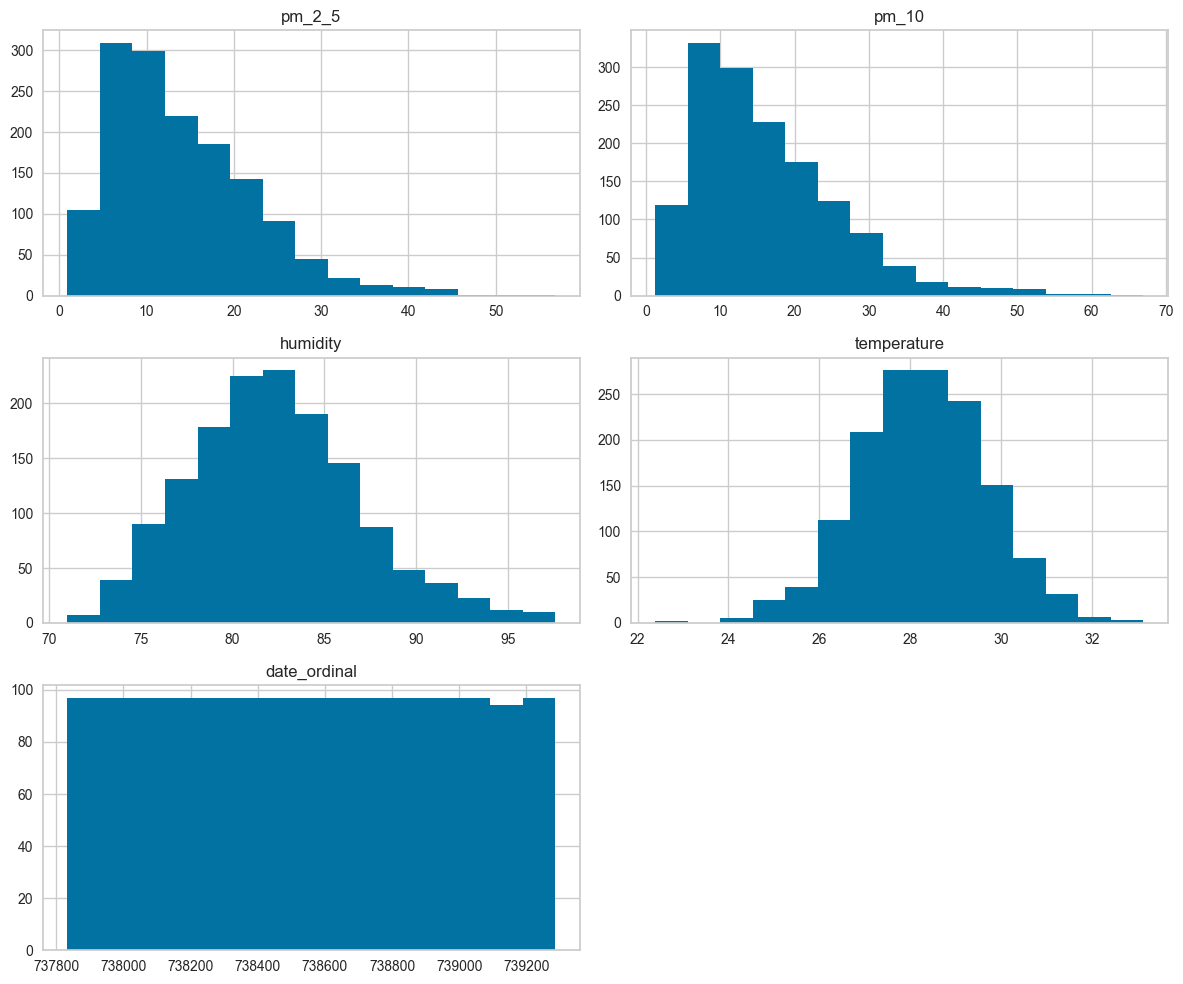

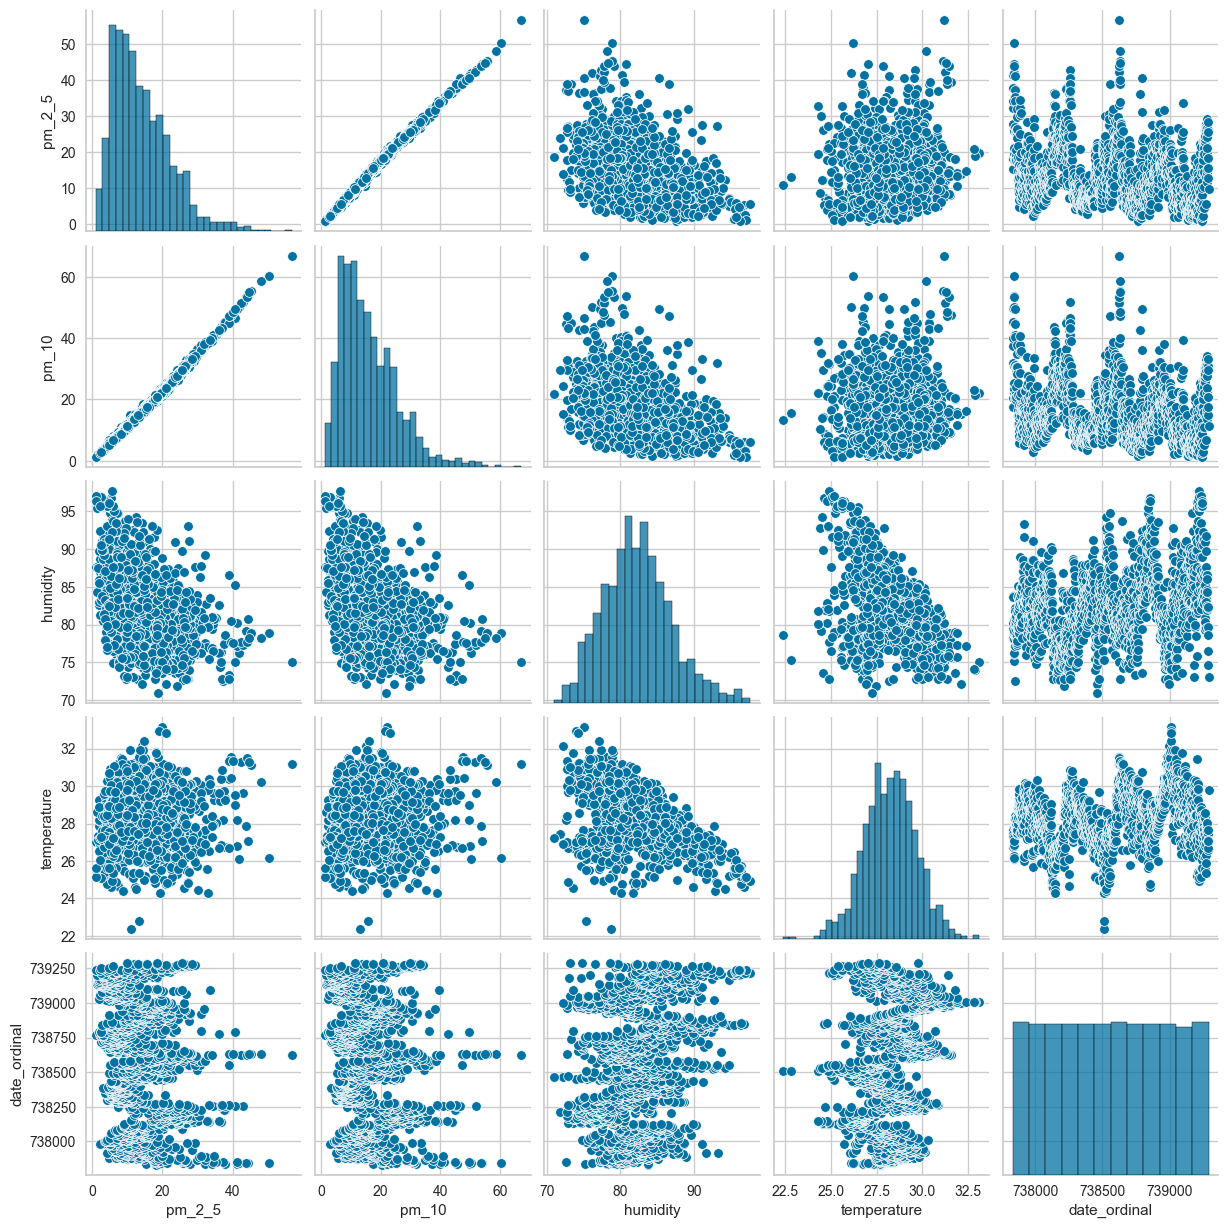

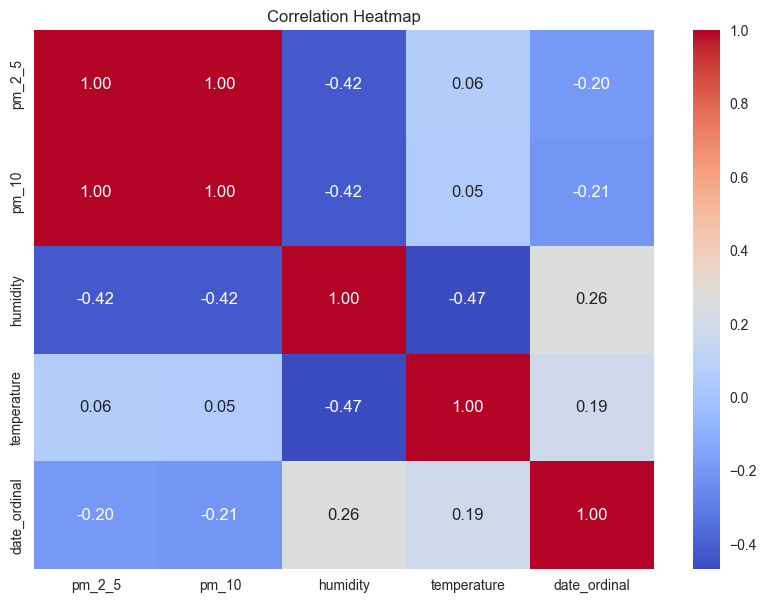

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# อ่านไฟล์ CSV
filename = r'C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\unknow-m_1d.csv'  # เปลี่ยนชื่อไฟล์ตามต้องการ
df = pd.read_csv(filename)

# ✅ แปลงคอลัมน์วันที่ให้เป็น datetime
df['date'] = pd.to_datetime(df['date'])

# ✅ สร้างคอลัมน์ใหม่ที่เป็นตัวเลขแทนวันที่
df['date_ordinal'] = df['date'].map(lambda x: x.toordinal())

# ✅ แสดงข้อมูล 5 แถวแรก
print("ข้อมูล 5 แถวแรก:")
print(df.head())

# ✅ ข้อมูลสรุป
print("\nข้อมูลสรุป (Summary):")
print(df.describe())

# ✅ ตรวจสอบค่าที่หายไป
print("\nจำนวนค่าที่หายไป:")
print(df.isnull().sum())

# ✅ คำนวณ Correlation (ตัดคอลัมน์วันที่ออก)
print("\nCorrelation ระหว่างคอลัมน์ตัวเลข:")
df_numeric = df.drop(columns=['date'])  # เอาแค่ตัวเลข
print(df_numeric.corr())

# ✅ พล็อตกราฟเพื่อดูแพทเทิร์นข้อมูล

# 1️⃣ Histogram: ดูการกระจายของแต่ละตัวแปร
df_numeric.hist(bins=15, figsize=(12,10))
plt.tight_layout()
plt.show()

# 2️⃣ Pairplot: ดูความสัมพันธ์ของตัวแปรทั้งหมด
sns.pairplot(df_numeric)
plt.show()

# 3️⃣ Heatmap: แสดง Correlation ของตัวแปรทั้งหมด
plt.figure(figsize=(10,7))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [28]:
import pandas as pd
from pycaret.regression import *

# 1) อ่านข้อมูล
df = pd.read_csv(r'C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\unknow-m_1d.csv')

# (ทางเลือก) หากคอลัมน์ date เป็น datetime ให้แปลงก่อน
df['date'] = pd.to_datetime(df['date'])

# (ทางเลือก) อาจแยก date เป็น feature อื่น เช่น วัน เดือน ปี
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# (หากไม่ต้องการคอลัมน์ date จริง ๆ แล้วใช้ drop() ออก หรือเก็บไว้ถ้ามีประโยชน์)
df.drop(columns=['date'], inplace=True)

# 2) ตั้งค่าการทำงานของ PyCaret (Regression)
#    ระบุ target='pm_2_5', session_id (สุ่มหรือระบุเพื่อให้ได้ผลเท่าเดิมทุกครั้ง)
exp = setup(
    data=df,
    target='pm_2_5',
    train_size=0.8,
    session_id=42,       # เพื่อควบคุม random state ให้ reproducible
    normalize=True,      # (เลือกได้ตามต้องการ)
    ignore_features=None # หากต้องการ exclude คอลัมน์บางตัว
)

# 3) เปรียบเทียบโมเดลหลายๆ แบบ (เช่น Linear, RandomForest, XGBoost ฯลฯ)
best_model = compare_models()
print("Best Model:", best_model)

# 4) ปรับแต่ง (tune) โมเดลที่ดีที่สุด
tuned_best = tune_model(best_model, optimize='MAE')
print("Tuned Best Model:", tuned_best)

# 5) ประเมินโมเดลที่ผ่านการ tune แล้ว (สร้าง report เบื้องต้น)
evaluate_model(tuned_best)

# 6) สร้างโมเดลตัวสุดท้าย (finalize) เพื่อนำไปใช้งานจริง
final_model = finalize_model(tuned_best)

# 7) ทดสอบพยากรณ์บนชุดทดสอบ (หรือข้อมูลใหม่)
#    PyCaret จะแยกชุดทดสอบให้จากขั้นตอน setup() อยู่แล้ว
#    หากต้องการดู performance บน hold-out set ที่ PyCaret มีให้
pred_holdout = predict_model(final_model)
print("\nผลการพยากรณ์บนชุด hold-out (ตัวอย่าง 5 แถวแรก):")
print(pred_holdout.head())

# 8) หากมีข้อมูลใหม่ (new_data) ที่ไม่มีคอลัมน์ pm_2_5
#    ก็ใช้ predict_model เพื่อทำนายได้เลย
# new_data = pd.read_csv('new_data.csv')
# predictions_new = predict_model(final_model, data=new_data)
# print(predictions_new.head())


,Description,Value
0,Session id,42
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(1452, 7)"
4,Transformed data shape,"(1452, 7)"
5,Transformed train set shape,"(1161, 7)"
6,Transformed test set shape,"(291, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.2462,0.1772,0.3950,0.9974,0.0255,0.0205,0.0780
gbr,Gradient Boosting Regressor,0.2489,0.1785,0.4048,0.9973,0.0265,0.0212,0.0630
lr,Linear Regression,0.3317,0.2057,0.4502,0.9969,0.0420,0.0343,0.0120
ridge,Ridge Regression,0.3338,0.2058,0.4504,0.9969,0.0425,0.0348,0.0120
lar,Least Angle Regression,0.3317,0.2057,0.4502,0.9969,0.0420,0.0343,0.0100
br,Bayesian Ridge,0.3317,0.2057,0.4502,0.9969,0.0420,0.0343,0.0110
rf,Random Forest Regressor,0.2711,0.2176,0.4359,0.9968,0.0275,0.0224,0.1200
omp,Orthogonal Matching Pursuit,0.3524,0.2200,0.4661,0.9967,0.0432,0.0360,0.0130
huber,Huber Regressor,0.3083,0.2345,0.4747,0.9966,0.0332,0.0273,0.0120
dt,Decision Tree Regressor,0.3671,0.3681,0.5762,0.9944,0.0365,0.0304,0.0110


Best Model: ExtraTreesRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6692,1.8378,1.3557,0.9754,0.0926,0.0747
1,0.5817,0.5177,0.7195,0.9907,0.0948,0.0811
2,0.7091,1.0618,1.0304,0.9883,0.0814,0.0676
3,0.5600,0.4960,0.7043,0.9913,0.0726,0.0602
4,0.5620,0.5382,0.7336,0.9884,0.1132,0.0920
5,0.5238,0.4419,0.6648,0.9915,0.0895,0.0743
6,0.6001,0.5389,0.7341,0.9925,0.0704,0.0601
7,0.6190,0.6029,0.7765,0.9914,0.0805,0.0703
8,0.5679,0.5446,0.7380,0.9917,0.0670,0.0596


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Tuned Best Model: ExtraTreesRegressor(n_jobs=-1, random_state=42)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2268,0.0867,0.2944,0.9988,0.0233,0.0195



ผลการพยากรณ์บนชุด hold-out (ตัวอย่าง 5 แถวแรก):
          pm_10   humidity  temperature  day  month  year     pm_2_5  \
1036  18.684307  87.960739    28.534941   15     12  2023  17.478430   
1124  30.513683  75.637718    29.148829   12      3  2024  26.266674   
997   12.792700  88.471519    27.880259    6     11  2023  11.430511   
1316   5.924339  82.820168    29.027399   23      9  2024   5.128431   
529    9.401855  83.208748    28.632046   26      7  2022   8.347201   

      prediction_label  
1036         17.228034  
1124         26.385519  
997          11.832361  
1316          5.512239  
529           8.352299  


In [29]:
import pandas as pd
from pycaret.regression import *

# 1) อ่านข้อมูล
df = pd.read_csv(r'C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\unknow-m_1d.csv')

# (ทางเลือก) หากคอลัมน์ date เป็น datetime ให้แปลงก่อน
df['date'] = pd.to_datetime(df['date'])

# (ทางเลือก) อาจแยก date เป็น feature อื่น เช่น วัน เดือน ปี
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# (หากไม่ต้องการคอลัมน์ date จริง ๆ แล้วใช้ drop() ออก หรือเก็บไว้ถ้ามีประโยชน์)
df.drop(columns=['pm_10'], inplace=True)

# 2) ตั้งค่าการทำงานของ PyCaret (Regression)
#    ระบุ target='pm_2_5', session_id (สุ่มหรือระบุเพื่อให้ได้ผลเท่าเดิมทุกครั้ง)
exp = setup(
    data=df,
    target='pm_2_5',
    train_size=0.8,
    session_id=42,       # เพื่อควบคุม random state ให้ reproducible
    normalize=True,      # (เลือกได้ตามต้องการ)
    ignore_features=None # หากต้องการ exclude คอลัมน์บางตัว
)

# 3) เปรียบเทียบโมเดลหลายๆ แบบ (เช่น Linear, RandomForest, XGBoost ฯลฯ)
best_model = compare_models()
print("Best Model:", best_model)

# 4) ปรับแต่ง (tune) โมเดลที่ดีที่สุด
tuned_best = tune_model(best_model, optimize='MAE')
print("Tuned Best Model:", tuned_best)

# 5) ประเมินโมเดลที่ผ่านการ tune แล้ว (สร้าง report เบื้องต้น)
evaluate_model(tuned_best)

# 6) สร้างโมเดลตัวสุดท้าย (finalize) เพื่อนำไปใช้งานจริง
final_model = finalize_model(tuned_best)

# 7) ทดสอบพยากรณ์บนชุดทดสอบ (หรือข้อมูลใหม่)
#    PyCaret จะแยกชุดทดสอบให้จากขั้นตอน setup() อยู่แล้ว
#    หากต้องการดู performance บน hold-out set ที่ PyCaret มีให้
pred_holdout = predict_model(final_model)
print("\nผลการพยากรณ์บนชุด hold-out (ตัวอย่าง 5 แถวแรก):")
print(pred_holdout.head())

# 8) หากมีข้อมูลใหม่ (new_data) ที่ไม่มีคอลัมน์ pm_2_5
#    ก็ใช้ predict_model เพื่อทำนายได้เลย
# new_data = pd.read_csv('new_data.csv')
# predictions_new = predict_model(final_model, data=new_data)
# print(predictions_new.head())


,Description,Value
0,Session id,42
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(1452, 7)"
4,Transformed data shape,"(1452, 9)"
5,Transformed train set shape,"(1161, 9)"
6,Transformed test set shape,"(291, 9)"
7,Numeric features,5
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3.2132,19.3921,4.3845,0.7027,0.3196,0.3075,0.0840
rf,Random Forest Regressor,3.7673,26.2747,5.1003,0.5957,0.3633,0.3686,0.1290
knn,K Neighbors Regressor,3.8383,28.0486,5.2690,0.5726,0.3616,0.3536,0.0180
lightgbm,Light Gradient Boosting Machine,3.9755,28.8248,5.3527,0.5572,0.3847,0.3864,0.1940
gbr,Gradient Boosting Regressor,4.0960,29.9848,5.4500,0.5419,0.3891,0.4072,0.0670
ada,AdaBoost Regressor,5.2471,41.8194,6.4462,0.3575,0.5032,0.6451,0.0550
dt,Decision Tree Regressor,4.7915,45.7696,6.7485,0.2907,0.4865,0.4547,0.0180
lar,Least Angle Regression,5.2740,48.5468,6.9141,0.2703,0.4955,0.5621,0.0140
ridge,Ridge Regression,5.2729,48.5016,6.9128,0.2702,0.4960,0.5606,0.0150
br,Bayesian Ridge,5.2742,48.5104,6.9135,0.2701,0.4958,0.5614,0.0140


Best Model: ExtraTreesRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.5896,26.2726,5.1257,0.6487,0.3363,0.3477
1,3.1514,17.4889,4.1820,0.6853,0.3429,0.3664
2,4.3188,35.9073,5.9923,0.6048,0.3820,0.3784
3,3.6001,21.6740,4.6555,0.6216,0.3482,0.3370
4,3.4957,21.3818,4.6240,0.5396,0.3710,0.4125
5,3.3228,18.6101,4.3139,0.6420,0.3622,0.4021
6,3.7564,24.0204,4.9011,0.6678,0.3344,0.3318
7,3.8368,27.3455,5.2293,0.6104,0.3752,0.3883
8,3.8059,29.5418,5.4352,0.5484,0.3674,0.3592


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Tuned Best Model: ExtraTreesRegressor(n_jobs=-1, random_state=42)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.3813,0.3019,0.5495,0.9957,0.0467,0.0350



ผลการพยากรณ์บนชุด hold-out (ตัวอย่าง 5 แถวแรก):
           date   humidity  temperature  day  month  year     pm_2_5  \
1036 2023-12-15  87.960739    28.534941   15     12  2023  17.478430   
1124 2024-03-12  75.637718    29.148829   12      3  2024  26.266674   
997  2023-11-06  88.471519    27.880259    6     11  2023  11.430511   
1316 2024-09-23  82.820168    29.027399   23      9  2024   5.128431   
529  2022-07-26  83.208748    28.632046   26      7  2022   8.347201   

      prediction_label  
1036         17.921489  
1124         25.818014  
997          11.520359  
1316          5.401063  
529           8.307114  


In [30]:
import pandas as pd
from pycaret.regression import *

# 1) อ่านข้อมูล
df = pd.read_csv(r'C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\unknow-m_1d.csv')

# (ทางเลือก) หากคอลัมน์ date เป็น datetime ให้แปลงก่อน
df['date'] = pd.to_datetime(df['date'])

# (ทางเลือก) อาจแยก date เป็น feature อื่น เช่น วัน เดือน ปี
df['year'] = df['date'].dt.year

# (หากไม่ต้องการคอลัมน์ date จริง ๆ แล้วใช้ drop() ออก หรือเก็บไว้ถ้ามีประโยชน์)
df.drop(columns=['pm_10'], inplace=True)

# 2) ตั้งค่าการทำงานของ PyCaret (Regression)
#    ระบุ target='pm_2_5', session_id (สุ่มหรือระบุเพื่อให้ได้ผลเท่าเดิมทุกครั้ง)
exp = setup(
    data=df,
    target='pm_2_5',
    train_size=0.8,
    session_id=42,       # เพื่อควบคุม random state ให้ reproducible
    normalize=True,      # (เลือกได้ตามต้องการ)
    ignore_features=None # หากต้องการ exclude คอลัมน์บางตัว
)

# 3) เปรียบเทียบโมเดลหลายๆ แบบ (เช่น Linear, RandomForest, XGBoost ฯลฯ)
best_model = compare_models()
print("Best Model:", best_model)

# 4) ปรับแต่ง (tune) โมเดลที่ดีที่สุด
tuned_best = tune_model(best_model, optimize='MAE')
print("Tuned Best Model:", tuned_best)

# 5) ประเมินโมเดลที่ผ่านการ tune แล้ว (สร้าง report เบื้องต้น)
evaluate_model(tuned_best)

# 6) สร้างโมเดลตัวสุดท้าย (finalize) เพื่อนำไปใช้งานจริง
final_model = finalize_model(tuned_best)

# 7) ทดสอบพยากรณ์บนชุดทดสอบ (หรือข้อมูลใหม่)
#    PyCaret จะแยกชุดทดสอบให้จากขั้นตอน setup() อยู่แล้ว
#    หากต้องการดู performance บน hold-out set ที่ PyCaret มีให้
pred_holdout = predict_model(final_model)
print("\nผลการพยากรณ์บนชุด hold-out (ตัวอย่าง 5 แถวแรก):")
print(pred_holdout.head())

# 8) หากมีข้อมูลใหม่ (new_data) ที่ไม่มีคอลัมน์ pm_2_5
#    ก็ใช้ predict_model เพื่อทำนายได้เลย
# new_data = pd.read_csv('new_data.csv')
# predictions_new = predict_model(final_model, data=new_data)
# print(predictions_new.head())


,Description,Value
0,Session id,42
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(1452, 5)"
4,Transformed data shape,"(1452, 7)"
5,Transformed train set shape,"(1161, 7)"
6,Transformed test set shape,"(291, 7)"
7,Numeric features,3
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3.3747,21.4445,4.6105,0.6704,0.3297,0.3202,0.0760
rf,Random Forest Regressor,3.7769,26.4580,5.1177,0.5933,0.3642,0.3694,0.1210
lightgbm,Light Gradient Boosting Machine,3.9755,28.8248,5.3527,0.5572,0.3847,0.3864,0.1910
knn,K Neighbors Regressor,3.8714,29.3129,5.3815,0.5532,0.3692,0.3597,0.0180
gbr,Gradient Boosting Regressor,4.0969,29.9886,5.4503,0.5419,0.3889,0.4073,0.0490
ada,AdaBoost Regressor,5.4182,43.6476,6.5959,0.3224,0.5163,0.6765,0.0380
dt,Decision Tree Regressor,4.8039,45.4647,6.7220,0.2960,0.4811,0.4572,0.0150
lar,Least Angle Regression,5.2729,48.5017,6.9128,0.2702,0.4960,0.5605,0.0140
br,Bayesian Ridge,5.2734,48.5064,6.9131,0.2702,0.4957,0.5613,0.0180
ridge,Ridge Regression,5.2729,48.5015,6.9128,0.2702,0.4960,0.5606,0.0140


Best Model: ExtraTreesRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.9817,32.1790,5.6727,0.5697,0.3821,0.4129
1,3.4882,20.0500,4.4777,0.6392,0.3730,0.4221
2,4.7102,40.1479,6.3362,0.5581,0.4075,0.4296
3,4.0780,25.5512,5.0548,0.5539,0.3799,0.4018
4,3.8267,23.1237,4.8087,0.5021,0.3958,0.4645
5,3.7043,22.5867,4.7525,0.5655,0.4049,0.4705
6,4.1731,29.6741,5.4474,0.5897,0.3634,0.3720
7,4.2251,33.5351,5.7910,0.5223,0.4118,0.4350
8,4.2508,34.3134,5.8578,0.4754,0.3967,0.4129


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Tuned Best Model: ExtraTreesRegressor(n_jobs=-1, random_state=42)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4679,0.4664,0.6829,0.9933,0.0551,0.0420



ผลการพยากรณ์บนชุด hold-out (ตัวอย่าง 5 แถวแรก):
           date   humidity  temperature  year     pm_2_5  prediction_label
1036 2023-12-15  87.960739    28.534941  2023  17.478430         17.334528
1124 2024-03-12  75.637718    29.148829  2024  26.266674         25.825688
997  2023-11-06  88.471519    27.880259  2023  11.430511         11.622621
1316 2024-09-23  82.820168    29.027399  2024   5.128431          5.403239
529  2022-07-26  83.208748    28.632046  2022   8.347201          8.341961


In [41]:
import pandas as pd
from pycaret.regression import *

# 1) อ่านข้อมูล
df = pd.read_csv(r'C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\unknow-m_1d.csv')

# (ทางเลือก) หากคอลัมน์ date เป็น datetime ให้แปลงก่อน
df['date'] = pd.to_datetime(df['date'])

# (ทางเลือก) อาจแยก date เป็น feature อื่น เช่น วัน เดือน ปี
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# (หากไม่ต้องการคอลัมน์ date จริง ๆ แล้วใช้ drop() ออก หรือเก็บไว้ถ้ามีประโยชน์)
df.drop(columns=['pm_10','humidity','temperature'], inplace=True)

# 2) ตั้งค่าการทำงานของ PyCaret (Regression)
#    ระบุ target='pm_2_5', session_id (สุ่มหรือระบุเพื่อให้ได้ผลเท่าเดิมทุกครั้ง)
exp = setup(
    data=df,
    target='pm_2_5',
    train_size=0.8,
    session_id=42,       # เพื่อควบคุม random state ให้ reproducible
    normalize=True,      # (เลือกได้ตามต้องการ)
    ignore_features=['pm_10','humidity','temperature'] # หากต้องการ exclude คอลัมน์บางตัว
)

# 3) เปรียบเทียบโมเดลหลายๆ แบบ (เช่น Linear, RandomForest, XGBoost ฯลฯ)
best_model = compare_models()
print("Best Model:", best_model)

# 4) ปรับแต่ง (tune) โมเดลที่ดีที่สุด
tuned_best = tune_model(best_model, optimize='MAE')
print("Tuned Best Model:", tuned_best)

# 5) ประเมินโมเดลที่ผ่านการ tune แล้ว (สร้าง report เบื้องต้น)
evaluate_model(tuned_best)

# 6) สร้างโมเดลตัวสุดท้าย (finalize) เพื่อนำไปใช้งานจริง
final_model = finalize_model(tuned_best)

# 7) ทดสอบพยากรณ์บนชุดทดสอบ (หรือข้อมูลใหม่)
#    PyCaret จะแยกชุดทดสอบให้จากขั้นตอน setup() อยู่แล้ว
#    หากต้องการดู performance บน hold-out set ที่ PyCaret มีให้
pred_holdout = predict_model(final_model)
print("\nผลการพยากรณ์บนชุด hold-out (ตัวอย่าง 5 แถวแรก):")
print(pred_holdout.head())

# 8) หากมีข้อมูลใหม่ (new_data) ที่ไม่มีคอลัมน์ pm_2_5
#    ก็ใช้ predict_model เพื่อทำนายได้เลย
new_data = pd.read_csv(r'C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\AeroSURE-m-1d.csv')
predictions_new = predict_model(final_model, data=new_data)
print(predictions_new.head())


,Description,Value
0,Session id,42
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(1452, 5)"
4,Transformed data shape,"(1452, 7)"
5,Transformed train set shape,"(1161, 7)"
6,Transformed test set shape,"(291, 7)"
7,Ignore features,3
8,Numeric features,3
9,Date features,1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.7918,16.4052,4.0315,0.7476,0.2917,0.2675,0.0720
rf,Random Forest Regressor,3.3081,21.0825,4.5738,0.6750,0.3411,0.3375,0.0920
lightgbm,Light Gradient Boosting Machine,3.8863,27.1773,5.2015,0.5784,0.3996,0.4113,0.1840
knn,K Neighbors Regressor,3.8442,27.5777,5.2347,0.5764,0.3758,0.3850,0.0180
dt,Decision Tree Regressor,4.0071,34.4382,5.8474,0.4688,0.4142,0.3832,0.0140
gbr,Gradient Boosting Regressor,4.4734,36.1691,5.9866,0.4480,0.4331,0.4749,0.0380
ada,AdaBoost Regressor,5.2721,43.5453,6.5841,0.3188,0.5043,0.6418,0.0220
ridge,Ridge Regression,5.7467,55.6747,7.4208,0.1582,0.5334,0.6317,0.0150
br,Bayesian Ridge,5.7477,55.6737,7.4207,0.1582,0.5334,0.6328,0.0160
lar,Least Angle Regression,5.7467,55.6749,7.4208,0.1581,0.5334,0.6317,0.0140


Best Model: ExtraTreesRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.6445,26.1463,5.1133,0.6504,0.3656,0.4002
1,3.5227,20.4777,4.5252,0.6315,0.3892,0.4412
2,4.5094,37.3901,6.1147,0.5885,0.3916,0.3921
3,3.4608,19.4354,4.4086,0.6607,0.3305,0.3408
4,3.7090,24.1761,4.9169,0.4795,0.4087,0.4723
5,3.6130,20.7442,4.5546,0.6009,0.3909,0.4482
6,3.9046,26.2993,5.1283,0.6363,0.3701,0.3694
7,3.7994,27.7313,5.2661,0.6049,0.3953,0.4080
8,3.7427,27.9497,5.2867,0.5727,0.3639,0.3588


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Tuned Best Model: ExtraTreesRegressor(n_jobs=-1, random_state=42)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.5081,0.4769,0.6906,0.9932,0.0611,0.0474



ผลการพยากรณ์บนชุด hold-out (ตัวอย่าง 5 แถวแรก):
           date  day  month  year     pm_2_5  prediction_label
1036 2023-12-15   15     12  2023  17.478430         17.602863
1124 2024-03-12   12      3  2024  26.266674         27.017403
997  2023-11-06    6     11  2023  11.430511         11.751806
1316 2024-09-23   23      9  2024   5.128431          5.566826
529  2022-07-26   26      7  2022   8.347201          8.208039


KeyError: "['day', 'month', 'year'] not in index"

In [40]:
import pandas as pd

# 1) อ่านไฟล์ CSV
df = pd.read_csv(r'C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\AeroSURE-m-1d.csv')

# 2) แปลงคอลัมน์ date เป็น datetime
df['date'] = pd.to_datetime(df['date'])

# 3) สร้างคอลัมน์ day, month, year จาก date
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# 4) ระบุลำดับคอลัมน์ที่ต้องการ
#    สมมติคอลัมน์ทั้งหมดที่มีคือ date, pm_2_5, pm_10, temperature, humidity, day, month, year
new_order = ['date', 'day', 'month', 'year', 'pm_2_5']

# 5) เรียงคอลัมน์ตาม new_order
df = df[new_order]

# 6) (ถ้าต้องการบันทึกไฟล์กลับ)
df.to_csv('AeroSURE-m-1d.csv', index=False)

# 7) ตรวจสอบผลลัพธ์
print(df.head())
print("\nคอลัมน์ทั้งหมดหลังเรียงแล้ว:\n", df.columns)


        date  day  month  year    pm_2_5
0 2021-08-19   19      8  2021  7.086071
1 2021-08-20   20      8  2021  6.924858
2 2021-08-21   21      8  2021  5.991887
3 2021-08-22   22      8  2021  7.371436
4 2021-08-23   23      8  2021  3.834712

คอลัมน์ทั้งหมดหลังเรียงแล้ว:
 Index(['date', 'day', 'month', 'year', 'pm_2_5'], dtype='object')
